In [1]:
import keras
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas
from keras import Sequential
from keras.layers import *
from keras.models import Model
import keras.backend as K
from keras.optimizers import SGD, Adam
from keras.callbacks import LearningRateScheduler
from keras.models import *

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


input1 = Missing image (Masked by cloud)

input2 = Referenced images (cloud-free)

### Implement Model

In [2]:
input1 = Input(shape=(400,400,1), name='input1')
input2 = Input(shape=(400,400,1), name='input2')
input3 = Input(shape=(400,400,1), name='input3')

conv_1 = Conv2D(30, (3, 3), padding='same')(input1)
conv_2 = Conv2D(30, (3, 3), padding='same')(input2)
conv_3 = Conv2D(60, (3, 3), padding='same')(input3)

concat_1_2 = concatenate([conv_1, conv_2], axis=-1)
concat_1_2 = Activation('relu')(concat_1_2)

# concat_1_2 = Dropout(0.5)(concat_1_2)

feature_3 = Conv2D(filters=20, kernel_size=(3, 3),padding='same')(concat_1_2)
feature_5 = Conv2D(filters=20, kernel_size=(5, 5),padding='same')(concat_1_2)
feature_7 = Conv2D(filters=20, kernel_size=(7, 7),padding='same')(concat_1_2)
feature_3_5_7 = concatenate([feature_3, feature_5, feature_7])
feature_3_5_7 = Activation('relu')(feature_3_5_7)

# feature_3_5_7 = Dropout(0.5)(feature_3_5_7)

sum0 = add([concat_1_2, feature_3_5_7])

conv1 = Conv2D(filters=60, kernel_size=(3,3), padding='same',activation='relu')(sum0)
conv2 = Conv2D(filters=60, kernel_size=(3,3), padding='same',activation='relu')(conv1)

sum1 = add([conv2, conv_3])
conv3 = Conv2D(filters=60, kernel_size=(3,3), dilation_rate=2, padding='same',activation='relu')(sum1)
conv4 = Conv2D(filters=60, kernel_size=(3,3), dilation_rate=3, padding='same',activation='relu')(conv3)
conv5 = Conv2D(filters=60, kernel_size=(3,3), dilation_rate=2, padding='same',activation='relu')(conv4)
sum2 = add([conv5, conv_3])

conv6 = Conv2D(filters=60, kernel_size=(3,3), padding='same',activation='relu')(sum2)
# conv6 = Dropout(0.5)(conv6)

conv6_2 = add([conv6, conv1])

conv7 = Conv2D(filters=1, kernel_size=(3,3), padding='same')(conv6_2)

model = Model([input1, input2, input3], conv7)
    

#### Define PSNR Loss Metrics, remains loss function MSE ; Step Decay for Callbacks

In [3]:
def PSNRLoss(y_true, y_pred):
    return -10. * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.)

In [4]:
def step_decay(epoch):
    initial_lrate = 0.0003
    drop = 0.5
    
    epochs_drop = 5
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

### Config Model

In [5]:
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8) 
model.compile(optimizer=adam, loss='mean_squared_error', metrics=[PSNRLoss])
model.load_weights('final_small_weight.h5')

## Load data for testing

In [6]:
import spectral as spy

In [7]:
def addCloudMaskOverData(data, mask):
    maskedData = np.copy(data)
    maskedData[np.asarray(mask) != 0] = 0
    return maskedData

In [8]:
def readHDRFile(file_name, band):
    img = spy.open_image(file_name)
    data = img.read_band(band)
    return data

In [9]:
input1 = readHDRFile('manually_test/input_without_mask.hdr', 0)

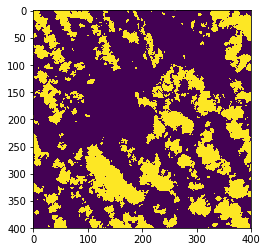

In [10]:
import cv2, rasterio

mask = rasterio.open('TriAn_20130417_BQA.TIF','r').read(1)
mask = mask[:,186:186+1011]
mask = cv2.resize(mask, dsize=(400, 400))
plt.imshow(mask)

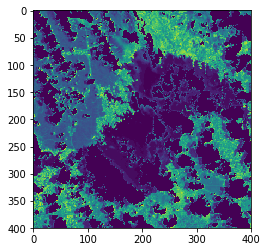

In [11]:
input1 = addCloudMaskOverData(input1, mask)
plt.imshow(input1)

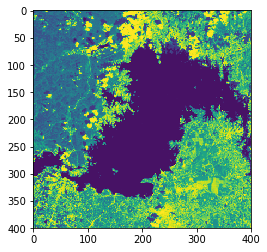

In [12]:
# Choose randomly
ref = readHDRFile('manually_test/ref/input_without_mask.hdr', 0)
plt.imshow(ref)

In [13]:
mask = np.reshape(mask, (1, 400, 400))

In [14]:
input1 = input1.reshape((1, 400, 400, 1))
ref = ref.reshape((1, 400, 400, 1))
mask = input1 + np.multiply(ref, np.reshape(mask, (mask.shape[0], 400, 400, 1)))

In [15]:
output = model.predict([input1, ref, mask])

Input

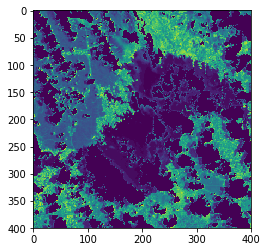

In [16]:
plt.imshow(input1[0,:,:,0])

Predicted

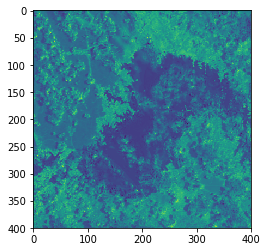

In [17]:
plt.imshow(output[0,:,:,0])

Test on Model (Batch Size = 8)

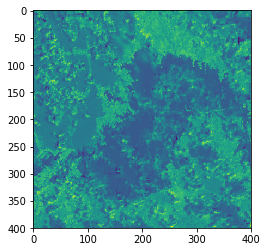

In [19]:
model.load_weights('final_small_weight_b8.h5')
output2 = model.predict([input1, ref, mask])
plt.imshow(output2[0,:,:,0])